In [1]:
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from scipy.io.matlab import loadmat
import tensorflow as tf
import numpy as np
import datetime
import os

%load_ext tensorboard

In [2]:
tf.random.set_seed(9)

In [3]:
!wget -c https://www.cs.toronto.edu/~tijmen/affNIST/32x/transformed/training_and_validation_batches.zip

--2020-12-15 16:46:37--  https://www.cs.toronto.edu/~tijmen/affNIST/32x/transformed/training_and_validation_batches.zip
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 730609891 (697M) [application/zip]
Saving to: ‘training_and_validation_batches.zip’

training_and_valida 100%[===================>] 696.76M  83.0MB/s    in 7.3s    

2020-12-15 16:46:44 (95.5 MB/s) - ‘training_and_validation_batches.zip’ saved [730609891/730609891]



In [4]:
! unzip training_and_validation_batches.zip

Archive:  training_and_validation_batches.zip
   creating: training_and_validation_batches/
  inflating: training_and_validation_batches/1.mat  
  inflating: training_and_validation_batches/2.mat  
  inflating: training_and_validation_batches/3.mat  
  inflating: training_and_validation_batches/4.mat  
  inflating: training_and_validation_batches/5.mat  
  inflating: training_and_validation_batches/6.mat  
  inflating: training_and_validation_batches/7.mat  
  inflating: training_and_validation_batches/8.mat  
  inflating: training_and_validation_batches/9.mat  
  inflating: training_and_validation_batches/10.mat  
  inflating: training_and_validation_batches/11.mat  
  inflating: training_and_validation_batches/12.mat  
  inflating: training_and_validation_batches/13.mat  
  inflating: training_and_validation_batches/14.mat  
  inflating: training_and_validation_batches/15.mat  
  inflating: training_and_validation_batches/16.mat  
  inflating: training_and_validation_batches/17.mat  

In [5]:
batch_size = 256
epochs = 100

In [6]:
image_path = 'training_and_validation_batches/1.mat'
temp = loadmat(image_path)

x = temp['affNISTdata']['image'][0][0].reshape(40, 40, 60000)
x = np.moveaxis(x, -1, 0)
x = np.expand_dims(x, axis=-1)
x = x/255.0

y = temp['affNISTdata']['label_int'][0][0]
y = np.moveaxis(y, -1, 0)
y = y.astype(np.int32)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)

In [8]:
mnist_train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
mnist_train_ds = mnist_train_ds.shuffle(5000).batch(batch_size)

In [9]:
class Localization(tf.keras.layers.Layer):
    def __init__(self):
        super(Localization, self).__init__()
        self.pool1 = tf.keras.layers.MaxPool2D()
        self.conv1 = tf.keras.layers.Conv2D(20, [5, 5], activation='relu')
        self.pool2 = tf.keras.layers.MaxPool2D()
        self.conv2 = tf.keras.layers.Conv2D(20, [5, 5], activation='relu')
        self.flatten = tf.keras.layers.Flatten()
        self.fc1 = tf.keras.layers.Dense(20, activation='relu')
        self.fc2 = tf.keras.layers.Dense(6, activation=None, bias_initializer=tf.keras.initializers.constant([1.0, 0.0, 0.0, 0.0, 1.0, 0.0]), kernel_initializer='zeros')

    def build(self, input_shape):
        print("Building Localization Network with input shape:", input_shape)

    def compute_output_shape(self, input_shape):
        return [None, 6]

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        theta = self.fc2(x)
        theta = tf.keras.layers.Reshape((2, 3))(theta)
        return theta

In [10]:
class BilinearInterpolation(tf.keras.layers.Layer):
    def __init__(self, height=40, width=40):
        super(BilinearInterpolation, self).__init__()
        self.height = height
        self.width = width

    def compute_output_shape(self, input_shape):
        return [None, self.height, self.width, 1]

    def get_config(self):
        return {
            'height': self.height,
            'width': self.width,
        }
    
    def build(self, input_shape):
        print("Building Bilinear Interpolation Layer with input shape:", input_shape)

    def advance_indexing(self, inputs, x, y):
        '''
        Numpy like advance indexing is not supported in tensorflow, hence, this function is a hack around the same method
        '''        
        shape = tf.shape(inputs)
        batch_size, _, _ = shape[0], shape[1], shape[2]
        
        batch_idx = tf.range(0, batch_size)
        batch_idx = tf.reshape(batch_idx, (batch_size, 1, 1))
        b = tf.tile(batch_idx, (1, self.height, self.width))
        indices = tf.stack([b, y, x], 3)
        return tf.gather_nd(inputs, indices)

    def call(self, inputs):
        images, theta = inputs
        homogenous_coordinates = self.grid_generator(batch=tf.shape(images)[0])
        return self.interpolate(images, homogenous_coordinates, theta)

    def grid_generator(self, batch):
        x = tf.linspace(-1, 1, self.width)
        y = tf.linspace(-1, 1, self.height)
            
        xx, yy = tf.meshgrid(x, y)
        xx = tf.reshape(xx, (-1,))
        yy = tf.reshape(yy, (-1,))
        homogenous_coordinates = tf.stack([xx, yy, tf.ones_like(xx)])
        homogenous_coordinates = tf.expand_dims(homogenous_coordinates, axis=0)
        homogenous_coordinates = tf.tile(homogenous_coordinates, [batch, 1, 1])
        homogenous_coordinates = tf.cast(homogenous_coordinates, dtype=tf.float32)
        return homogenous_coordinates
    
    def interpolate(self, images, homogenous_coordinates, theta):

        with tf.name_scope("Transformation"):
            transformed = tf.matmul(theta, homogenous_coordinates)
            transformed = tf.transpose(transformed, perm=[0, 2, 1])
            transformed = tf.reshape(transformed, [-1, self.height, self.width, 2])
                
            x_transformed = transformed[:, :, :, 0]
            y_transformed = transformed[:, :, :, 1]
                
            x = ((x_transformed + 1.) * tf.cast(self.width, dtype=tf.float32)) * 0.5
            y = ((y_transformed + 1.) * tf.cast(self.height, dtype=tf.float32)) * 0.5

        with tf.name_scope("VariableCasting"):
            x0 = tf.cast(tf.math.floor(x), dtype=tf.int32)
            x1 = x0 + 1
            y0 = tf.cast(tf.math.floor(y), dtype=tf.int32)
            y1 = y0 + 1

            x0 = tf.clip_by_value(x0, 0, self.width-1)
            x1 = tf.clip_by_value(x1, 0, self.width-1)
            y0 = tf.clip_by_value(y0, 0, self.height-1)
            y1 = tf.clip_by_value(y1, 0, self.height-1)
            x = tf.clip_by_value(x, 0, tf.cast(self.width, dtype=tf.float32)-1.0)
            y = tf.clip_by_value(y, 0, tf.cast(self.height, dtype=tf.float32)-1)

        with tf.name_scope("AdvanceIndexing"):
            Ia = self.advance_indexing(images, x0, y0)
            Ib = self.advance_indexing(images, x0, y1)
            Ic = self.advance_indexing(images, x1, y0)
            Id = self.advance_indexing(images, x1, y1)

        with tf.name_scope("Interpolation"):
            x0 = tf.cast(x0, dtype=tf.float32)
            x1 = tf.cast(x1, dtype=tf.float32)
            y0 = tf.cast(y0, dtype=tf.float32)
            y1 = tf.cast(y1, dtype=tf.float32)
                            
            wa = (x1-x) * (y1-y)
            wb = (x1-x) * (y-y0)
            wc = (x-x0) * (y1-y)
            wd = (x-x0) * (y-y0)

            wa = tf.expand_dims(wa, axis=3)
            wb = tf.expand_dims(wb, axis=3)
            wc = tf.expand_dims(wc, axis=3)
            wd = tf.expand_dims(wd, axis=3)
                        
        return tf.math.add_n([wa*Ia + wb*Ib + wc*Ic + wd*Id])

In [11]:
bi = BilinearInterpolation()

In [12]:
image = np.zeros((2, 40, 40, 1))
image[0, 10:20, 10:20, :] = 1
image[1, 20:30, 20:30, :] = 1

# 45 degree rotation matrix
theta = np.asarray([[np.cos(np.pi/4), -np.sin(np.pi/4), 0], [np.sin(np.pi/4), np.cos(np.pi/4),0]])

In [13]:
result = bi([image, theta])


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Building Bilinear Interpolation Layer with input shape: [TensorShape([2, 40, 40, 1]), TensorShape([2, 3])]


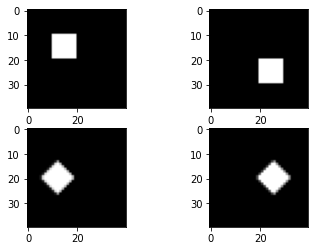

In [14]:
plt.subplot(2, 2, 1)
plt.imshow(image[0, :, :, 0], cmap='gray')

plt.subplot(2, 2, 2)
plt.imshow(image[1, :, :, 0], cmap='gray')

plt.subplot(2, 2, 3)
plt.imshow(result[0, :, :, 0], cmap='gray')

plt.subplot(2, 2, 4)
plt.imshow(result[1, :, :, 0], cmap='gray')

In [15]:
def get_model(input_shape):
    image = tf.keras.layers.Input(shape=input_shape)
    theta = Localization()(image)
    x = BilinearInterpolation(height=input_shape[0], width=input_shape[1])([image, theta])
    x = tf.keras.layers.Conv2D(64, [9, 9], activation='relu')(x)
    x = tf.keras.layers.MaxPool2D()(x)
    x = tf.keras.layers.Conv2D(64, [7, 7], activation='relu')(x)
    x = tf.keras.layers.MaxPool2D()(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.Dense(32, activation='relu')(x)
    x = tf.keras.layers.Dense(10, activation='softmax')(x)

    return tf.keras.models.Model(inputs=image, outputs=x)

In [16]:
model = get_model((40, 40, 1))

Building Localization Network with input shape: (None, 40, 40, 1)
Building Bilinear Interpolation Layer with input shape: [TensorShape([None, 40, 40, 1]), TensorShape([None, 2, 3])]


In [17]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 40, 40, 1)]  0                                            
__________________________________________________________________________________________________
localization (Localization)     (None, 2, 3)         30286       input_1[0][0]                    
__________________________________________________________________________________________________
bilinear_interpolation_1 (Bilin (None, 40, 40, 1)    0           input_1[0][0]                    
                                                                 localization[0][0]               
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 32, 32, 64)   5248        bilinear_interpolation

In [18]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [19]:
def schedular(epoch, lr):
    if epoch % 20 == 0 and epoch > 0:
        print("Learning Rate Updated")
        lr /= 10
    return lr

In [20]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
learning_rate_callback = tf.keras.callbacks.LearningRateScheduler(schedular)

In [21]:
history = model.fit(mnist_train_ds, epochs=epochs, callbacks=[tensorboard_callback, learning_rate_callback])

Epoch 1/100
  1/211 [..............................] - ETA: 0s - loss: 2.3026 - accuracy: 0.0664WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
211/211 [==============================] - 10s 48ms/step - loss: 1.9467 - accuracy: 0.5087
Epoch 2/100
211/211 [==============================] - 12s 55ms/step - loss: 1.7803 - accuracy: 0.6784
Epoch 3/100
211/211 [==============================] - 12s 56ms/step - loss: 1.7685 - accuracy: 0.6893
Epoch 4/100
211/211 [==============================] - 12s 56ms/step - loss: 1.7062 - accuracy: 0.7525
Epoch 5/100
211/211 [==============================] - 12s 58ms/step - loss: 1.6737 - accuracy: 0.7841
Epoch 6/100
211/211 [==============================] - 12s 59ms/step - loss: 1.6701 - accuracy: 0.7871
Epoch 7/100
211/211 

In [22]:
model.save_weights('./model/weights', save_format='tf')

In [23]:
stn = tf.keras.models.Model(inputs=model.inputs, outputs=[model.layers[1].output, model.layers[2].output])

In [24]:
theta, prediction = stn.predict(X_test)

/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:



 [[ 0.879925    0.09167187  0.33949822]
 [-0.04518849  0.86799157  0.23965745]]


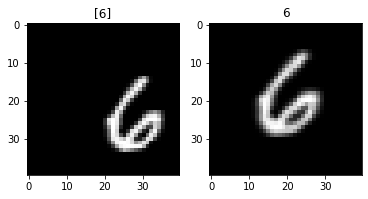

In [25]:
index = 203

plt.subplot(1,2,1)
plt.title(y_test[index])
plt.imshow(X_test[index, :, :, 0], cmap='gray')

plt.subplot(1, 2, 2)
plt.title(np.argmax(model.predict(np.expand_dims(X_test[index, :, :, 0], axis=0))))
plt.imshow(prediction[index, :, :, 0], cmap='gray')

print("\n", theta[index])